# Biweekly Report 4
**Spencer Shortt**


For this report, we will explore how to implement an MLP mixing model for image classification and make a comparison against a basic CNN model. This report focuses more on the setup of MLP mixing. We will be using CIFAR10 image dataset to test our models with. Our implementation of MLP mixing will come from https://towardsdatascience.com/mlp-mixer-is-all-you-need-20dbc7587fe4, and our understanding will come from the above article, the original paper https://arxiv.org/pdf/2105.01601.pdf, and a video going through the original paper at https://www.youtube.com/watch?v=7K4Z8RqjWIk


First, let's import our libraries. 

In [1]:
import tensorflow as tf
from keras.datasets import cifar10
from matplotlib import pyplot as plt
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import numpy as np
from tensorflow.keras import datasets, layers, models

Next we will make an mlp function with 2 dense layers, a GELU activation function between, and dropout. GELU, by the way, is just RELU but with weighting from the Gaussian CDF. GELU is often used when dealing with Batch/Layer normalization because they use gaussian distributions (although I always like playing with different activation functions, so this is something I'd like to explore another time). 

In [2]:
def mlp( x , hidden_dims ):
    y = tf.keras.layers.Dense( hidden_dims )( x )
    y = tf.nn.gelu( y )
    y = tf.keras.layers.Dense( x.shape[ -1 ] )( y )
    y = tf.keras.layers.Dropout( 0.4 )( y )
    return y

Next, we make our token and channel mixing functions, which will be explained further later on in the notebook. The layer normalization is used in lieu of batch normalization, and permute is the function we are using to transpose our data. Note that in each mixing processing we are calling on our mlp function above!

In [12]:
def token_mixing( x , token_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( x ) 
    # After transposition, shape of x -> ( batch_size , channels , num_patches )
    x = mlp( x , token_mixing_mlp_dims )
    return x
    
# Channel Mixing MLPs : Allow communication within channels ( features of embeddings )
def channel_mixing( x , channel_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = mlp( x , channel_mixing_mlp_dims )
    return x

Finally, we define our mixing function, which will be used to combine the token and channel mixing to create a mixer layer. After this will be ready to create our MLP mixing model!

In [3]:
def mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims ):
    # inputs x of are of shape ( batch_size , num_patches , channels )
    # Note: "channels" is used instead of "embedding_dims"
    
    # Add token mixing MLPs
    token_mixing_out = token_mixing( x , token_mixing_mlp_dims )
    # Shape of token_mixing_out -> ( batch_size , channels , num_patches )

    token_mixing_out = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( token_mixing_out )
    # Shape of transposition -> ( batch_size , num_patches , channels )
    
    #  Add skip connection
    token_mixing_out = tf.keras.layers.Add()( [ x , token_mixing_out ] )

    # Add channel mixing MLPs
    channel_mixing_out = channel_mixing( token_mixing_out , channel_mixing_mlp_dims )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )
    
    # Add skip connection
    channel_mixing_out = tf.keras.layers.Add()( [ channel_mixing_out , token_mixing_out ] )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )

    return channel_mixing_out

But first, let's load and look at some data so that we can train and test our model:

170498071/170498071 [==============================] - 3s 0us/step
(10000, 1)
(50000, 32, 32, 3)


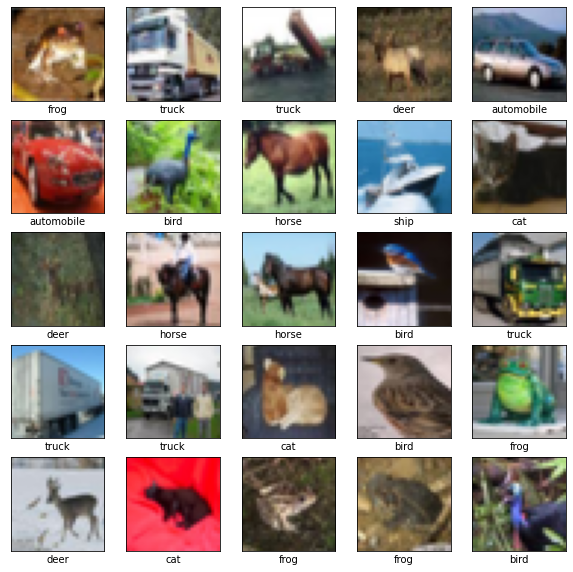

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

#print(type(train_images))
print(test_labels.shape)
print(train_images.shape)



class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()



We will go ahead and split our data into train, validation, and test splits. Although we don't explore multiple MLP mixing models in this report, this would be a next step, so we might as well get them set up for future explorations.

In [8]:
new_data = np.concatenate((train_images , test_images) , axis=0)

X_train = new_data[:42000]
X_valid = new_data[42000:51000]
X_test = new_data[51000:]


new_labels = np.concatenate((train_labels , test_labels) , axis=0)
y_train = new_labels[:42000]
y_valid = new_labels[42000:51000]
y_test = new_labels[51000:]

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)

(42000, 32, 32, 3)
(9000, 32, 32, 3)
(42000, 1)


Now that we have our data, we are finally ready to play with the MLP mixer! Below, we take an image from the original paper https://arxiv.org/pdf/2105.01601.pdf to illustrate how to model works. 

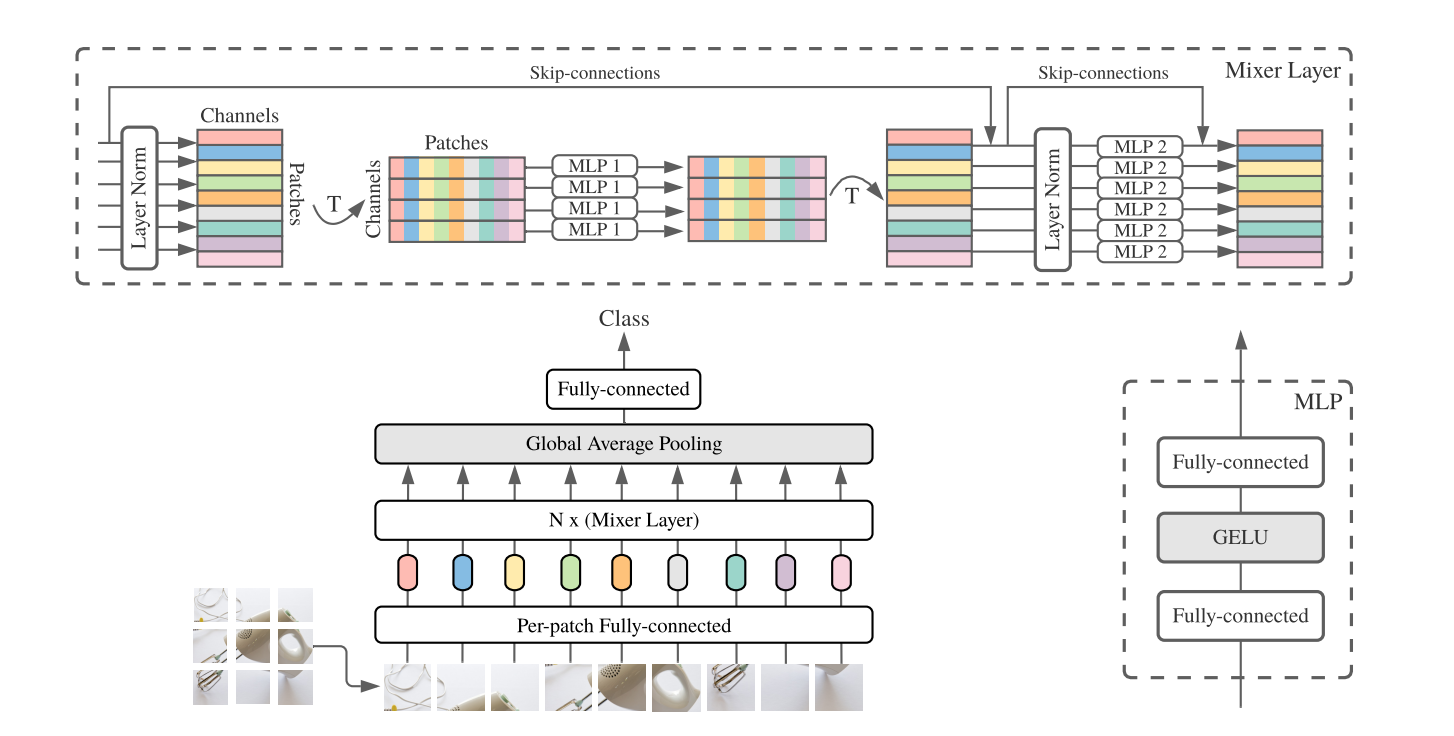

To start, we don't just put the raw data into our mlp mixing layer. First we will use 2-dimensional convolution to create C "patches" which will be the input for the channels, where C is the number of channels. 

The patches, also known as tokens and can be thought of as segments of an image, are then fed into the mixer function where they are first put through the token mixer, which includes layer normalization, a transposition (with the Permute function), and finally an mlp with two dense layers, a GELU activation function, and some Dropout. In token mixing, we are combining the same patches from different images into our two-layer-deep mixing MLP, hence the name token mixing. We then transpore the output to feed into the channel mixer.

While token mixing takes in multiple patches on the same channel from different images, channel mixing acts in an analogous way by mixing the information from channel to channel, hence another transposition is necessary before throwing the data through another mlp.

Throughout this process layer normalization is used instead of batch normalization.

After all the mixing layer normalization, we do a quick round of global pooling before ending with a fully connnected dense layer with a softmax activation function: 



In [6]:
hidden_dims = 128
token_mixing_mlp_dims = 64
channel_mixing_mlp_dims = 128
patch_size = 9
num_classes = 10
num_mixer_layers = 4
input_image_shape = ( 32 , 32 , 3 )

inputs = tf.keras.layers.Input( shape=input_image_shape )

# Conv2D to extract patches
patches = tf.keras.layers.Conv2D( hidden_dims , kernel_size=patch_size , strides=patch_size )( inputs )
# Resizing the patches
patches_reshape = tf.keras.layers.Reshape( ( patches.shape[ 1 ] * patches.shape[ 2 ] , patches.shape[ 3 ] ) )( patches )

x = patches_reshape
for _ in range( num_mixer_layers ):
    x = mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims )

# Classifier head
x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
x = tf.keras.layers.GlobalAveragePooling1D()( x )
outputs = tf.keras.layers.Dense( num_classes , activation='softmax' )( x )

model = tf.keras.models.Model( inputs , outputs )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 3, 3, 128)    31232       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 9, 128)       0           ['conv2d[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 9, 128)      256         ['reshape[0][0]']                
 alization)                                                                                   

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1313/1313 [==============================] - 87s 62ms/step - loss: 1.9416 - accuracy: 0.2814 - val_loss: 1.7335 - val_accuracy: 0.3732
Epoch 2/10
1313/1313 [==============================] - 77s 59ms/step - loss: 1.6542 - accuracy: 0.3983 - val_loss: 1.6091 - val_accuracy: 0.4290
Epoch 3/10
1313/1313 [==============================] - 75s 57ms/step - loss: 1.5578 - accuracy: 0.4343 - val_loss: 1.5288 - val_accuracy: 0.4537
Epoch 4/10
1313/1313 [==============================] - 78s 59ms/step - loss: 1.4853 - accuracy: 0.4615 - val_loss: 1.5494 - val_accuracy: 0.4626
Epoch 5/10
1313/1313 [==============================] - 77s 58ms/step - loss: 1.4363 - accuracy: 0.4815 - val_loss: 1.4250 - val_accuracy: 0.4857
Epoch 6/10
1313/1313 [==============================] - 78s 59ms/step - loss: 1.3984 - accuracy: 0.4956 - val_loss: 1.4302 - val_accuracy: 0.4982
Epoch 7/10
1313/1313 [==============================] - 77s 58ms/step - loss: 1.3613 - accuracy: 0.5046 - val_loss: 1.3717 - val_accura

After 10 epochs, we see our result on the validation data. Let's run the same data through a basic CNN for comparison:

In [13]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))


model.summary()


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

#history = model.fit(X_train, y_train, epochs = 3, batch_size = 64, validation_data = (X_valid, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

**Conclusion**

We see that the CNN performs a bit better on this particular dataset, although there is a lot of room to play with in the MLP mixing model. This is something I hope to explore in the future. And as the professor said, MLP mixing would be a very impressive method had CNN's not been invented first. In conclusion, this report was mostly about how to implement a MLP mixing model and take a longer look at what each step is doing. I learned a lot by going through the resources and creating this notebook, and hopefully you gained something from this as well! Thanks for reading!